In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Render a colored point cloud

This tutorial shows how to:
- set up a renderer 
- render the point cloud 
- vary the rendering settings such as compositing and camera position

## Import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [1]:
import os
import sys
import torch
import pytorch3d    

In [2]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

### Load a point cloud and corresponding colors

Load and create a **Point Cloud** object. 

**Pointclouds** is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes. 

If running this notebook using **Google Colab**, run the following cell to fetch the pointcloud data and save it at the path `data/PittsburghBridge`:
If running locally, the data is already available at the correct path. 

In [3]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2021-04-21 13:43:34--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘data/PittsburghBridge/pointcloud.npz.2’

pointcloud.npz.2      0%[                    ]       0  --.-KB/s               ^C


In [3]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
        
rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

In [4]:
rgb.shape

torch.Size([438544, 4])

## Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthgraphic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **alpha compositing**. Then we learn how to vary different components using the modular API.  

[1] <a href="https://arxiv.org/abs/1912.08804">SynSin: End to end View Synthesis from a Single Image.</a> Olivia Wiles, Georgia Gkioxari, Richard Szeliski, Justin Johnson. CVPR 2020.

In [5]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

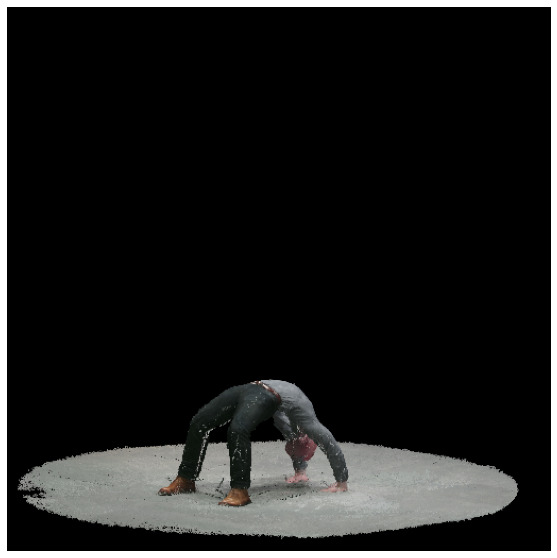

In [5]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [6]:
fragments = renderer.rasterizer(point_cloud)
fragments

PointFragments(idx=tensor([[[[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         ...,

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1,

We will now modify the **renderer** to use **alpha compositing** with a set background color. 

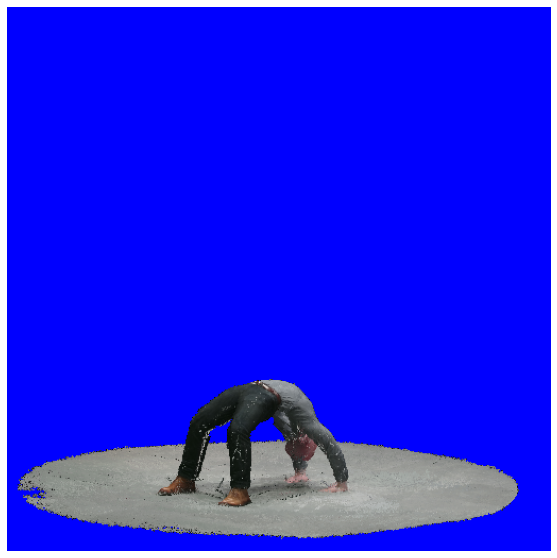

In [7]:
renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=AlphaCompositor(background_color=(0, 0, 1))
)
images = renderer(point_cloud)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **weighted compositing**. 

In [8]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an weighted compositor (3D points are
# weighted according to their distance to a pixel and accumulated using a weighted sum)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


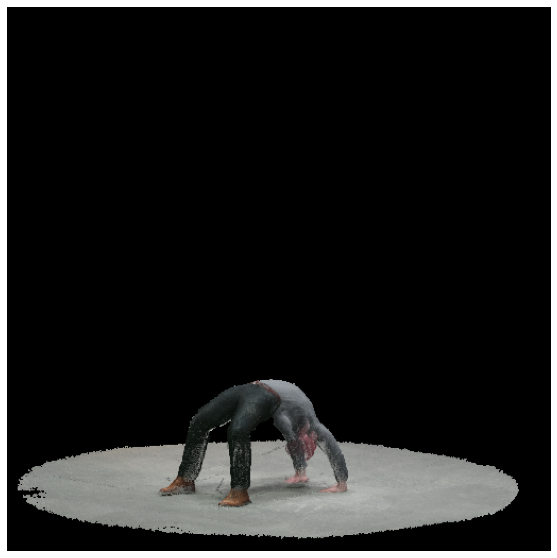

In [9]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

We will now modify the **renderer** to use **weighted compositing** with a set background color. 

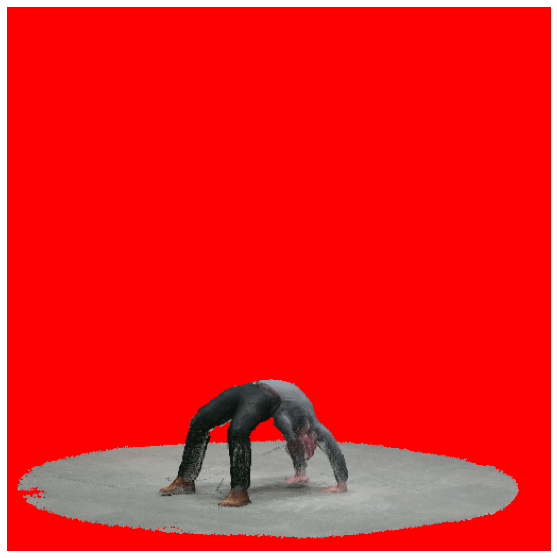

In [10]:
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    # Pass in background_color to the norm weighted compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case red
    compositor=NormWeightedCompositor(background_color=(1,0,0))
)
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

## Using the pulsar backend

Switching to the pulsar backend is easy! The pulsar backend has a compositor built-in, so the `compositor` argument is not required when creating it (a warning will be displayed if you provide it nevertheless). It pre-allocates memory on the rendering device, that's why it needs the `n_channels` at construction time.

All parameters for the renderer forward function are batch-wise except the background color (in this example, `gamma`) and you have to provide as many values as you have examples in your batch. The background color is optional and by default set to all zeros. You can find a detailed explanation of how gamma influences the rendering function here in the paper [Fast Differentiable Raycasting for Neural Rendering using
Sphere-based Representations](https://arxiv.org/pdf/2004.07484.pdf).

You can also use the `native` backend for the pulsar backend which already provides access to point opacity. The native backend can be imported from `pytorch3d.renderer.points.pulsar`; you can find examples for this in the folder `docs/examples`.

In [11]:
point_cloud.points_packed().shape

torch.Size([438544, 3])

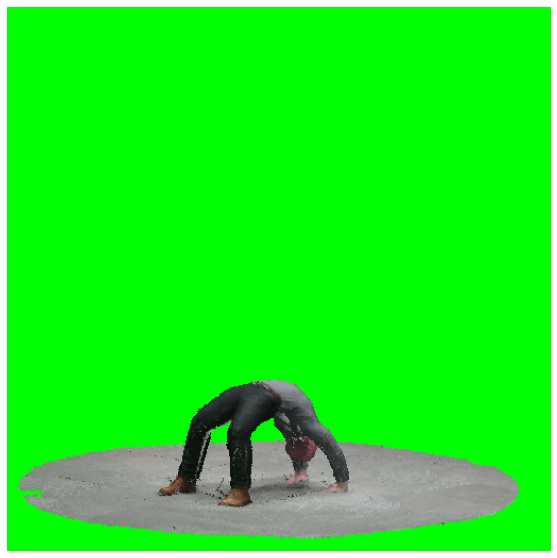

In [12]:
pulsar_renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = pulsar_renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [16]:
fragments = pulsar_renderer.rasterizer(point_cloud)
fragments

PointFragments(idx=tensor([[[[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1]],

         ...,

         [[-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [-1, -1,

In [19]:
rgb.shape

torch.Size([438544, 4])

In [20]:
torch.Tensor(pointcloud['rgb'][:, :3]).shape

torch.Size([438544, 3])

In [13]:
pointcloud

In [14]:
verts.shape

torch.Size([438544, 3])

In [15]:
norms = torch.nn.functional.normalize(torch.rand_like(verts), dim=1)
norms.shape

torch.Size([438544, 3])

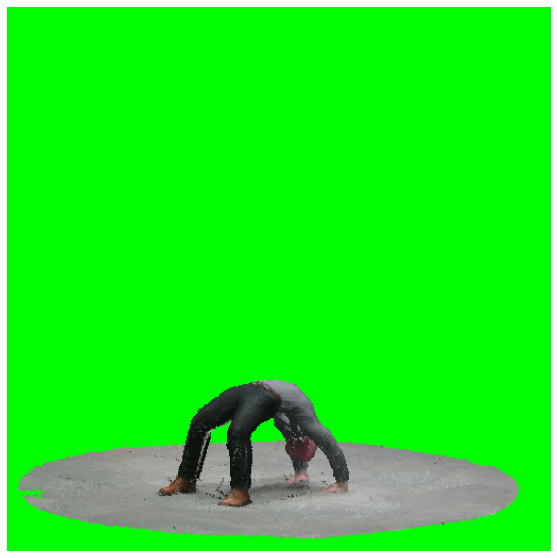

In [16]:
rgb = torch.Tensor(pointcloud['rgb'][:, :3]).to(device)

point_cloud = Pointclouds(points=[verts], normals=[norms], features=[rgb])

pulsar_renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=3
).to(device)

images = pulsar_renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

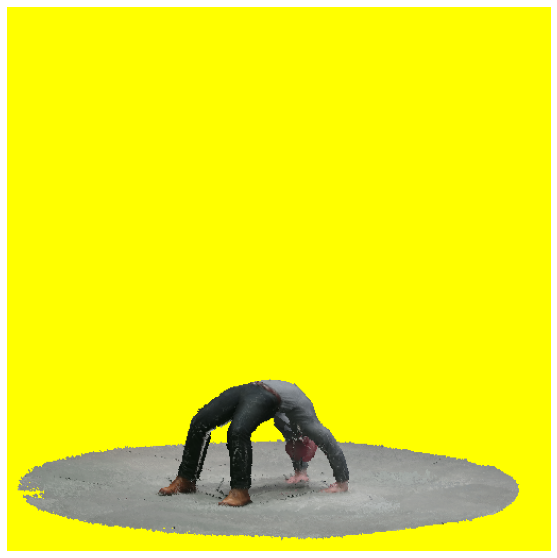

In [27]:
rgb = torch.Tensor(pointcloud['rgb'][:, :3]).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

pulsar_renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=3
).to(device)

images = pulsar_renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([1.0, 1.0, 0.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

### View pointclouds in Plotly figures

Here we use the PyTorch3D function `plot_scene` to render the pointcloud in a Plotly figure. `plot_scene` returns a plotly figure with trace and subplots defined by the input.

In [ ]:
plot_scene({
    "Pointcloud": {
        "person": point_cloud
    }
})

We will now render a batch of pointclouds. The first pointcloud is the same as above, and the second is all-black and offset by 2 in all dimensions so we can see them on the same plot. 

In [ ]:
point_cloud_batch = Pointclouds(points=[verts, verts + 2], features=[rgb, torch.zeros_like(rgb)])
# render both in the same plot in different traces
fig = plot_scene({
    "Pointcloud": {
        "person": point_cloud_batch[0],
        "person2": point_cloud_batch[1]
    }
})
fig.show()

In [ ]:
# render both in the same plot in one trace
fig = plot_scene({
    "Pointcloud": {
        "2 people": point_cloud_batch
    }
})
fig.show()

For batches, we can also use `plot_batch_individually` to avoid constructing the scene dictionary ourselves.

In [ ]:
# render both in 1 row in different subplots
fig2 = plot_batch_individually(point_cloud_batch, ncols=2)
fig2.show()

In [ ]:
# modify the plotly figure height and width
fig2.update_layout(height=500, width=500)
fig2.show()

We can also modify the axis arguments and axis backgrounds for either function, and title our plots in `plot_batch_individually`.

In [ ]:
fig3 = plot_batch_individually(
    point_cloud_batch, 
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    subplot_titles=["Pointcloud1", "Pointcloud2"], # this should have a title for each subplot, titles can be ""
    axis_args=AxisArgs(showgrid=True))
fig3.show()